# Manejo de datos raster

## Descripción general

En este capítulo, se muestran ejemplos de manejo de datos raster con Python.

Los datos se obtienen de servicios basados en la especificación [SpatioTemporal Asset Catalogs (STAC)](https://stacspec.org), la cual proporciona una estructura común para describir y catalogar recursos espacio temporales (ej. imágenes satelitales) a través de una interfaz de programación de aplicaciones (en inglés, [API o *Application Programming Interface*](https://es.wikipedia.org/wiki/Interfaz_de_programaci%C3%B3n_de_aplicaciones)). Puede explorar catálogos y API de tipo STAC en el sitio web [STAC browser](https://radiantearth.github.io/stac-browser/).

## Instalación de módulos

Algunos de los módulos que se utilizan en este capítulo son:

- [rasterio](https://rasterio.readthedocs.io/): para operaciones generales de manejo de datos raster.
- [xarray](https://docs.xarray.dev/): para manejo de arreglos multidimensionales.
- [rioxarray](https://corteva.github.io/rioxarray/stable/): extensión de xarray para trabajar con rasterio. 
- [pystac_client](https://pystac-client.readthedocs.io/): para trabajar con catálogos STAC.

```
# Instalación, mediante mamba, de módulos para manejo de datos raster y acceso a recursos STAC
mamba install -c conda-forge xarray rioxarray earthpy xarray-spatial pystac-client python-graphviz
```

## Lectura

### Acceso a recursos STAC

In [1]:
# Carga de pystac_client, para acceder datos en STAC
from pystac_client import Client

Se accede el API de [Earth Search](https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v0), el cual proporciona acceso a conjuntos de datos públicos en Amazon Web Services (AWS).

La función [Client.open()](https://pystac-client.readthedocs.io/en/stable/api.html#pystac_client.Client.open) retorna un objeto tipo `Client`, el cual se utiliza para acceder el API (ej. realizar búsquedas). 

In [2]:
# URL del API STAC
api_url = "https://earth-search.aws.element84.com/v1"

# Cliente para acceso a los datos
client = Client.open(api_url)

En este ejemplo, se accederá una colección de imágenes Sentinel en formato [Cloud Optimized GeoTIFF (COG)](https://www.cogeo.org/).

In [3]:
# Colección
collection = "sentinel-2-l2a"

Se especifica un punto (x, y) para buscar imágenes que lo contengan.

In [4]:
# Punto para búsqueda
from shapely.geometry import Point
point = Point(-84, 10)

La función [Client.search()](https://pystac-client.readthedocs.io/en/stable/api.html#pystac_client.Client.search) realiza una búsqueda con base en criterios como colección e intersección.

In [5]:
# Búsqueda de items (imágenes) que contienen el punto
search = client.search(collections=[collection],
                       intersects=point,
                       max_items=10,
)

In [6]:
# Cantidad total de items que retorna la búsqueda
search.matched()

545

In [7]:
# Items retornados
items = search.get_all_items()

len(items)

/home/mfvargas/miniconda3/envs/pf0907-2023-ii/lib/python3.11/site-packages/pystac_client/item_search.py:850: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


10

In [8]:
# Identificadores de los items retornados
for item in items:
    print(item)

<Item id=S2A_16PHS_20231111_0_L2A>
<Item id=S2B_16PHS_20231106_0_L2A>
<Item id=S2A_16PHS_20231101_0_L2A>
<Item id=S2A_16PHS_20231012_0_L2A>
<Item id=S2B_16PHS_20231007_0_L2A>
<Item id=S2A_16PHS_20231002_0_L2A>
<Item id=S2B_16PHS_20230927_0_L2A>
<Item id=S2A_16PHS_20230922_0_L2A>
<Item id=S2B_16PHS_20230917_0_L2A>
<Item id=S2B_16PHS_20230907_0_L2A>


Para estudiarlo en detalle, se selecciona un item.

In [9]:
# Primer item (imagen) retornado
item = items[0]

**Nótese que al seleccionarse el item mediante una posición en una colección, la imagen correspondiente puede cambiar si se actualizan los datos del API**.

In [10]:
# Algunos atributos del item
print(item.id)
print(item.datetime)
print(item.geometry)
print(item.properties)

S2A_16PHS_20231111_0_L2A
2023-11-11 16:10:31.270000+00:00
{'type': 'Polygon', 'coordinates': [[[-84.2564449365329, 10.843245515578996], [-84.26505426889273, 9.851332389975521], [-83.26529071959975, 9.841749072035094], [-83.25354975084628, 10.83267581874028], [-84.2564449365329, 10.843245515578996]]]}
{'created': '2023-11-11T22:33:56.736Z', 'platform': 'sentinel-2a', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 98.155785, 'proj:epsg': 32616, 'mgrs:utm_zone': 16, 'mgrs:latitude_band': 'P', 'mgrs:grid_square': 'HS', 'grid:code': 'MGRS-16PHS', 'view:sun_azimuth': 148.533968682752, 'view:sun_elevation': 57.4415103820978, 's2:degraded_msi_data_percentage': 1.2542, 's2:nodata_pixel_percentage': 0, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 0.000292, 's2:cloud_shadow_percentage': 1.568104, 's2:vegetation_percentage': 0.2298, 's2:not_vegetated_percentage': 0.029436, 's2:water_percentage': 0.008371, 's2:unclassified_percentage': 0.008

Ahora, se realiza la búsqueda con base en un rectángulo delimitador (*bounding box*) generado a partir del punto que se definió anteriormente.

In [11]:
# Rectángulo para búsquedas
bbox = point.buffer(0.01).bounds
bbox

(-84.01, 9.99, -83.99, 10.01)

También se restringe la búsqueda para retornar solo aquellas imágenes con cobertura de nubes menor al 10%.

In [12]:
# Búsqueda con nuevos criterios
search = client.search(collections=[collection],
                       bbox=bbox,
                       datetime="2022-01-01/2022-10-30",
                       query=["eo:cloud_cover<10"]) # no deben haber espacios alrededor del '<'

# Cantidad total de items que retorna la búsqueda
search.matched()

1

In [13]:
# Items retornados
items = search.get_all_items()

len(items)

1

In [14]:
# Segundo item retornado y algunos de sus atributos
item = items[0]

print(item.datetime)
print(item.properties)

2022-06-04 16:10:32.485000+00:00
{'created': '2022-11-06T09:36:00.890Z', 'platform': 'sentinel-2b', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 8.426005, 'proj:epsg': 32616, 'mgrs:utm_zone': 16, 'mgrs:latitude_band': 'P', 'mgrs:grid_square': 'HS', 'grid:code': 'MGRS-16PHS', 'view:sun_azimuth': 55.9328358345023, 'view:sun_elevation': 66.7533976878781, 's2:degraded_msi_data_percentage': 0.0065, 's2:nodata_pixel_percentage': 7e-06, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 0.094432, 's2:cloud_shadow_percentage': 1.402189, 's2:vegetation_percentage': 72.135556, 's2:not_vegetated_percentage': 3.596571, 's2:water_percentage': 13.979244, 's2:unclassified_percentage': 0.366004, 's2:medium_proba_clouds_percentage': 2.679723, 's2:high_proba_clouds_percentage': 5.175458, 's2:thin_cirrus_percentage': 0.570824, 's2:snow_ice_percentage': 0, 's2:product_type': 'S2MSI2A', 's2:processing_baseline': '04.00', 's2:product_uri': 'S2B_MSIL2A_20

#### Ejercicio

Realice el [ejercicio de búsqueda de imágenes Landsat 8](https://carpentries-incubator.github.io/geospatial-python/05-access-data/index.html#exercise-downloading-landsat-8-assets) del curso [The Carpentries Incubator - Introduction to Geospatial Raster and Vector Data with Python](https://carpentries-incubator.github.io/geospatial-python/). Puede cambiar el punto de la búsqueda por otro que sea de su interés.

### *Assets*

Cada item retornado contiene un conjunto de "activos" (*assets*) (ej. bandas) que también pueden accederse mediante el API.

In [15]:
# Activos (assets) del item
assets = item.assets

# Llaves
assets.keys()

dict_keys(['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2'])

In [16]:
# Contenido completo de los items
assets.items()

dict_items([('aot', <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/16/P/HS/2022/6/S2B_16PHS_20220604_0_L2A/AOT.tif>), ('blue', <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/16/P/HS/2022/6/S2B_16PHS_20220604_0_L2A/B02.tif>), ('coastal', <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/16/P/HS/2022/6/S2B_16PHS_20220604_0_L2A/B01.tif>), ('granule_metadata', <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/16/P/HS/2022/6/S2B_16PHS_20220604_0_L2A/granule_metadata.xml>), ('green', <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/16/P/HS/2022/6/S2B_16PHS_20220604_0_L2A/B03.tif>), ('nir', <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/16/P/HS/2022/6/S2B_16PHS_20220604_0_L2A/B08.tif>), ('nir08', <Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/16/P/HS/2022/6/S2

In [17]:
# Nombres de los activos
for key, asset in assets.items():
    print(f"{key}: {asset.title}")

aot: Aerosol optical thickness (AOT)
blue: Blue (band 2) - 10m
coastal: Coastal aerosol (band 1) - 60m
granule_metadata: None
green: Green (band 3) - 10m
nir: NIR 1 (band 8) - 10m
nir08: NIR 2 (band 8A) - 20m
nir09: NIR 3 (band 9) - 60m
red: Red (band 4) - 10m
rededge1: Red edge 1 (band 5) - 20m
rededge2: Red edge 2 (band 6) - 20m
rededge3: Red edge 3 (band 7) - 20m
scl: Scene classification map (SCL)
swir16: SWIR 1 (band 11) - 20m
swir22: SWIR 2 (band 12) - 20m
thumbnail: Thumbnail image
tileinfo_metadata: None
visual: True color image
wvp: Water vapour (WVP)
aot-jp2: Aerosol optical thickness (AOT)
blue-jp2: Blue (band 2) - 10m
coastal-jp2: Coastal aerosol (band 1) - 60m
green-jp2: Green (band 3) - 10m
nir-jp2: NIR 1 (band 8) - 10m
nir08-jp2: NIR 2 (band 8A) - 20m
nir09-jp2: NIR 3 (band 9) - 60m
red-jp2: Red (band 4) - 10m
rededge1-jp2: Red edge 1 (band 5) - 20m
rededge2-jp2: Red edge 2 (band 6) - 20m
rededge3-jp2: Red edge 3 (band 7) - 20m
scl-jp2: Scene classification map (SCL)
swi

In [18]:
# Imagen thumbnail
assets["thumbnail"]

<Asset href=https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/16/P/HS/2022/6/S2B_16PHS_20220604_0_L2A/thumbnail.jpg>

In [19]:
# URL del thumbnail
assets["thumbnail"].href

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/16/P/HS/2022/6/S2B_16PHS_20220604_0_L2A/thumbnail.jpg'

## Visualización

In [20]:
# Carga de rioxarray, para graficar datos raster
import rioxarray

El módulo rioxarray provee un conjunto de funciones para manipular imágenes.

Las bandas pueden abrirse con la función [open_rasterio()](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray-open-rasterio) y graficarse con [plot()](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.plot.html#xarray.DataArray.plot) y [plot.imshow()](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.plot.imshow.html).

#### Visualización del `thumbnail`

El `thumbnail` es una imagen de tres bandas tipo "True Color".

In [21]:
# Vista general de la imagen (True Color)
thumbnail = rioxarray.open_rasterio(item.assets['thumbnail'].href)

thumbnail

/home/mfvargas/miniconda3/envs/pf0907-2023-ii/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<xarray.DataArray (band: 3, y: 343, x: 343)>
[352947 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 0.5 1.5 2.5 3.5 4.5 ... 339.5 340.5 341.5 342.5
  * y            (y) float64 0.5 1.5 2.5 3.5 4.5 ... 339.5 340.5 341.5 342.5
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [22]:
# Dimensiones de la imagen (bandas, filas, columnas)
thumbnail.shape

(3, 343, 343)

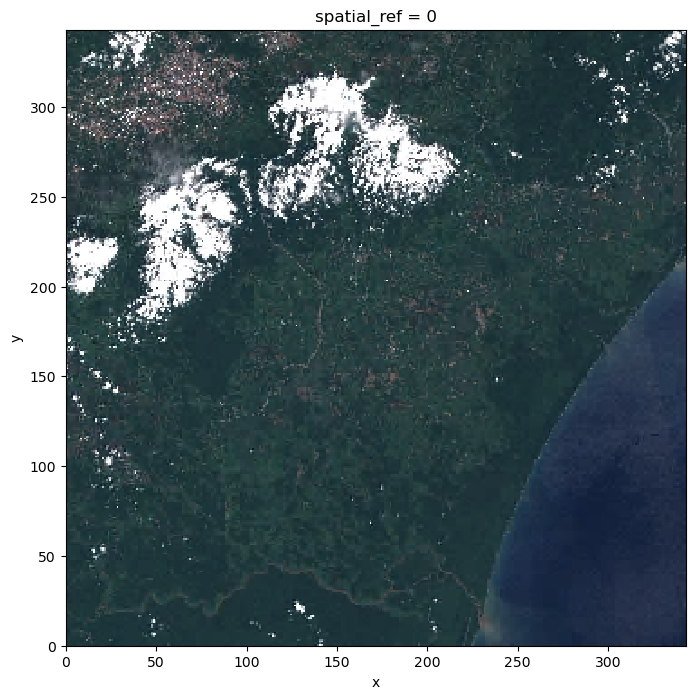

In [23]:
# Graficación de imagen RGB
thumbnail.plot.imshow(figsize=(8, 8))

#### Visualización de una banda

In [24]:
# Banda 9
b_09 = rioxarray.open_rasterio(assets["nir09"].href)

b_09

<xarray.DataArray (band: 1, y: 1830, x: 1830)>
[3348900 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 8e+05 8.001e+05 8.001e+05 ... 9.097e+05 9.098e+05
  * y            (y) float64 1.2e+06 1.2e+06 1.2e+06 ... 1.09e+06 1.09e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

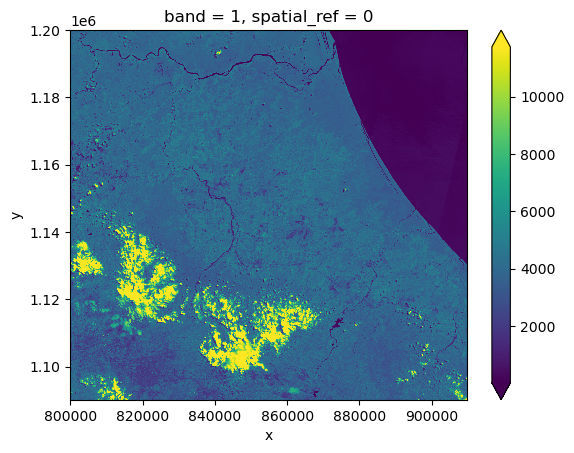

In [25]:
# Graficación de la banda
# robust=True calcula el rango de colores entre los percentiles 2 y 98
b_09.plot(robust=True)

## Ejemplo de álgebra raster: cálculo del NDVI

Seguidamente, se utiliza la imagen Sentinel para calcular el [Índice de vegetación de diferencia normalizada (NDVI)](https://es.wikipedia.org/wiki/%C3%8Dndice_de_vegetaci%C3%B3n_de_diferencia_normalizada).

Se separan las dos bandas necesarias para el cálculo: la roja y la infrarroja cercana.

In [26]:
# Bandas necesarias para el cálculo
b_red = rioxarray.open_rasterio(assets["red"].href)
b_nir = rioxarray.open_rasterio(assets["nir"].href)

Para efectos del ejemplo, se reduce el área en la que va a realizarse el cálculo.

In [27]:
# Buffer (rectángulo) de 15 km alrededor de un punto
point = Point(859872, 1168852)
bbox = point.buffer(15000).bounds

# Recorte 
b_red_clip = b_red.rio.clip_box(*bbox)
b_nir_clip = b_nir.rio.clip_box(*bbox)

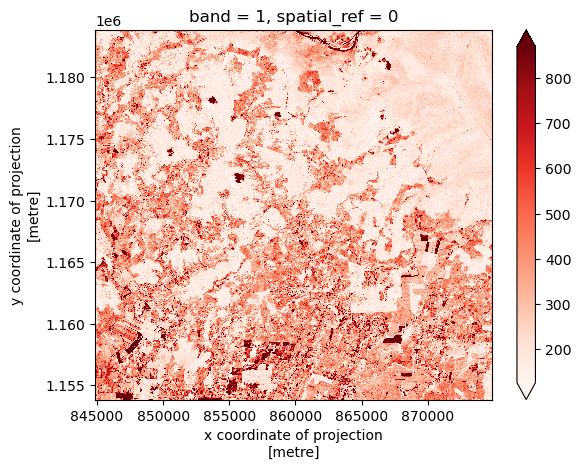

In [28]:
# Visualización de la banda roja
b_red_clip.plot(robust=True, cmap="Reds")

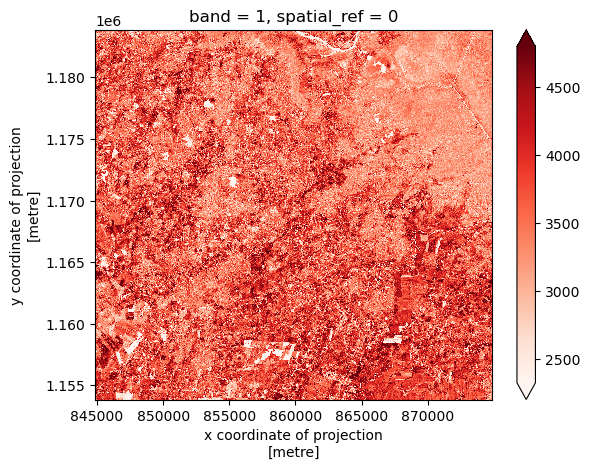

In [29]:
# Visualización de la banda infrarroja cercana
b_nir_clip.plot(robust=True, cmap="Reds")

In [30]:
# Dimensiones de las bandas
print(b_red_clip.shape, b_nir_clip.shape)

(1, 3001, 3001) (1, 3001, 3001)


Para realizar la operación algebraica, las bandas deben tener las mismas dimensiones. Así que se reduce la resolución de la banda roja para hacerla igual a la resolución de la infrarroja cercana.

In [31]:
# Se homogeneizan las dimensiones
#b_red_clip_matched = b_red_clip.rio.reproject_match(b_nir_clip)
#print(b_red_clip_matched.shape)

Ya puede calcularse el NDVI.

In [32]:
# Cálculo del NDVI
# ndvi = (b_nir_clip - b_red_clip_matched)/ (b_nir_clip + b_red_clip_matched)
ndvi = (b_nir_clip - b_red_clip)/ (b_nir_clip + b_red_clip)

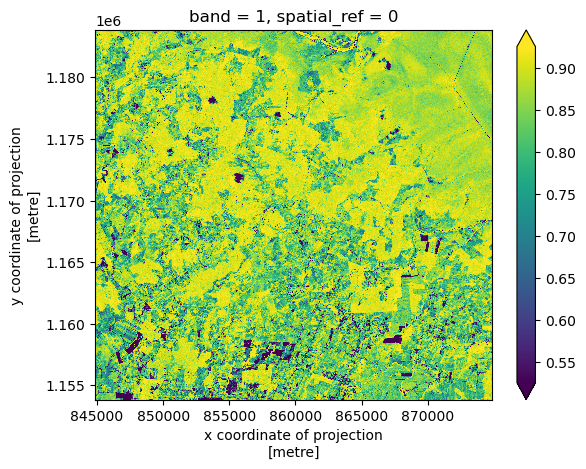

In [33]:
# Visualización del cálculo del NDVI
ndvi.plot(robust=True)

## Escritura

La función [to_raster()](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray.raster_array.RasterArray.to_raster) exporta los datos a un archivo raster.

In [34]:
# Se guarda el resultado del cálculo del NDVI en un archivo
# ndvi.rio.to_raster("ndvi.tif")

## Recursos de interés

- [The Carpentries Incubator - Introduction to Geospatial Raster and Vector Data with Python](https://carpentries-incubator.github.io/geospatial-python/)
- [Geospatial Raster & Vector Data with Python](https://www.youtube.com/watch?v=Ce7GuGIf3r0)